* Dates:
    * Older moves might not be torrented
    * Month: Blockbusters are released in May and December, No good movies released January - April, Kids are on summer cvaction during summer months.
* Production Budget: 
    * Might be outliers. Take log if outliers, Remove outliers, Create new feature that is binning production budget
* Rating: Is there a relationship with Number of torrents, look at mean, median torrents per rating. Maybe group ratings together for example G, PG, PG-13 in one group R in another
* Genre as a feature. Maybe keep a subset maybe create new ratings by combing other ratings

In [1]:
import pandas as pd
import numpy as np
import string
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
df = pd.read_csv('data/data.csv', encoding='latin-1')
df = df[['Released', 'Prod_Budget', 'Rated', 'Runtime', 'Genre', 'Total_Torrents']]
print(len(df))
df.head()

1653


,Released,Prod_Budget,Rated,Runtime,Genre,Total_Torrents
0,2009-12-18,425000000.0,PG-13,162,"Action, Adventure, Fantasy",1450.0
1,2015-11-06,300000000.0,PG-13,148,"Action, Adventure, Thriller",647.0
2,2012-07-20,275000000.0,PG-13,164,"Action, Adventure, Drama",861.0
3,2012-03-09,275000000.0,PG-13,132,"Action, Adventure, Sci-Fi",723.0
4,2010-11-24,260000000.0,PG,100,"Animation, Adventure, Comedy",563.0


# Convert to date time => Month, Year

In [3]:
df['Released'] = pd.to_datetime(df['Released'])
df['Year'] = pd.DatetimeIndex(df['Released']).year
df['Month'] = pd.DatetimeIndex(df['Released']).month

df.head()

,Released,Prod_Budget,Rated,Runtime,Genre,Total_Torrents,Year,Month
0,2009-12-18,425000000.0,PG-13,162,"Action, Adventure, Fantasy",1450.0,2009,12
1,2015-11-06,300000000.0,PG-13,148,"Action, Adventure, Thriller",647.0,2015,11
2,2012-07-20,275000000.0,PG-13,164,"Action, Adventure, Drama",861.0,2012,7
3,2012-03-09,275000000.0,PG-13,132,"Action, Adventure, Sci-Fi",723.0,2012,3
4,2010-11-24,260000000.0,PG,100,"Animation, Adventure, Comedy",563.0,2010,11


In [4]:
df.sort_values('Year').head()

,Released,Prod_Budget,Rated,Runtime,Genre,Total_Torrents,Year,Month
1647,1916-09-05,385907.0,NOT RATED,197,"Drama, History, War",37.0,1916,9
1643,1933-04-07,672000.0,UNRATED,100,"Adventure, Fantasy, Horror",107.0,1933,4
1617,1939-08-25,2777000.0,PASSED,102,"Adventure, Family, Fantasy",175.0,1939,8
1593,1953-02-05,4000000.0,APPROVED,77,"Animation, Adventure, Family",142.0,1953,2
1375,1956-10-05,13500000.0,APPROVED,220,"Adventure, Biography, Drama",135.0,1956,10


In [31]:
# select only binned runtimes of significance

df = df.loc[df['Year'] >= 2000]
df.sort_values('Year').head()

,Released,Prod_Budget,Rated,Runtime,Genre,Total_Torrents,Year,Month,Genre_Single
993,2000-12-22,28000000.0,R,99,"Action, Fantasy, Horror",65.0,2000,12,Action
1497,2000-09-29,9000000.0,PG-13,112,"Drama, Comedy",56.0,2000,9,Drama
589,2000-02-11,50000000.0,R,119,"Adventure, Drama, Thriller",157.0,2000,2,Drama
1492,2000-01-21,9000000.0,PG-13,91,"Comedy, Drama, Romance",24.0,2000,1,Drama
1490,2000-09-08,9000000.0,R,119,"Action, Crime, Drama",55.0,2000,9,Drama


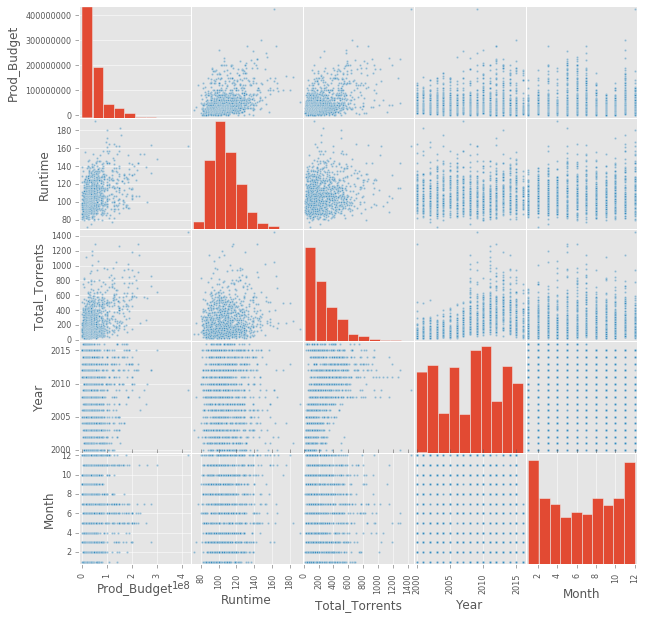

In [32]:
# Lets take a look at our entire model
plt.rcParams['figure.figsize'] = (10, 10)
_ = pd.tools.plotting.scatter_matrix(df)

In [7]:
# unique list of grouped genres as a string
unq_genres = df['Genre'].unique()
unq_genres = unq_genres.tolist()

# unique list of grouped genres as a list of genres
lst_grp_genres = []
for lst in unq_genres:
    temp = []
    for genre in lst.split(','):
         temp.append(genre)
    lst_grp_genres.append(temp)

#print(len(unq_genres))
#print(unq_genres[:10])

In [8]:
# unique list of individual genres
ind_genre = set()

for lst in unq_genres:
    for genre in lst.split(','):
        ind_genre.add(genre.strip())
ind_genre = sorted(ind_genre)

#print(len(ind_genre))
#print(ind_genre)

In [9]:
# dictionary - count of genre occurences
count = defaultdict(lambda:0)

for genre in ind_genre:
    count[genre] = df.Genre.str.contains(genre).sum()

import operator
srt = sorted(count.items(), key=operator.itemgetter(1))
srt = srt[::-1]
#print(srt)

In [10]:
def split_to_array(ser):
    split_array = np.array(ser.strip().replace(',','').split(' '))
    return pd.Series(split_array)

genres = df.Genre.apply(split_to_array)
genres = pd.Series(genres.values.ravel()).dropna()
genres = genres.value_counts().sort_values(ascending=False)

In [11]:
def convert_frequency(ser, genres=genres):
    split_array = np.array(ser.strip().replace(',','').split(' '))
    genre = genres.loc[split_array].argmax()
    return genre

df['Genre_Single'] = df.Genre.apply(convert_frequency)
#df_test=df[['Genre','Genre_Single']]

# Select only significant values from dataframe

In [12]:
# select only genres of significance
genre = ['Action', 'Adventure', 'Comedy', 'Crime', 'Drama']
df_sub = df.loc[df['Genre_Single'].isin(genre)]

# select only genres of significance
ratings = ['PG-13', 'PG', 'G', 'R']
df_sub = df_sub.loc[df_sub['Rated'].isin(ratings)]

# select only binned runtimes of significance
#duration = ['80-100', '100-120', '120-140']
#mask = (df_sub['Runtime'] > 80) & (df_sub['Runtime'] <= 140)
#df_sub = df_sub.loc[mask]

#df_sub['Runtime'].value_counts()
#df_sub['Genre_Single'].value_counts()
#df_sub['Rated'].value_counts()
df_sub.describe()

,Prod_Budget,Runtime,Total_Torrents,Year,Month
count,1.486000e+03,1486.000000,1486.000000,1486.000000,1486.000000
mean,5.091483e+07,110.874159,226.755047,2003.812248,6.754374
std,4.523104e+07,17.953128,201.882522,8.846107,3.357423
min,6.800000e+04,72.000000,17.000000,1960.000000,1.000000
25%,2.000000e+07,98.000000,86.250000,1999.000000,4.000000
50%,3.800000e+07,108.000000,160.000000,2005.000000,7.000000
75%,6.500000e+07,121.000000,303.750000,2011.000000,10.000000
max,4.250000e+08,229.000000,1450.000000,2016.000000,12.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10ee47d30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x10eefd710>]], dtype=object)

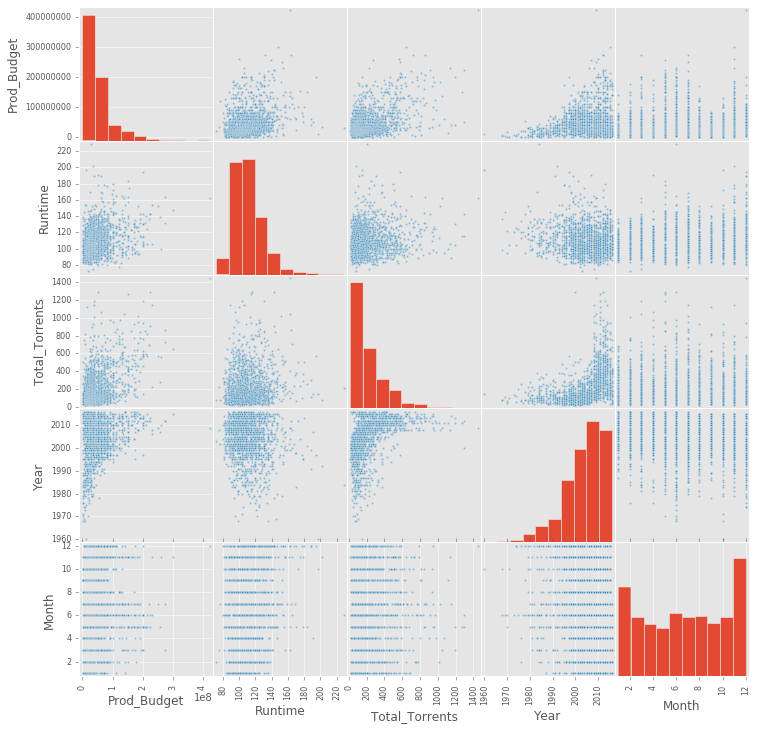

In [13]:
# Lets take a look at our entire model
plt.rcParams['figure.figsize'] = (12, 12)
pd.tools.plotting.scatter_matrix(df_sub)

In [14]:
from patsy import dmatrices

y, x = dmatrices('Total_Torrents ~ Prod_Budget + Genre_Single + Runtime', data=df_sub, return_type='dataframe')

In [15]:
y.head()

,Total_Torrents
0,1450.0
1,647.0
2,861.0
3,723.0
4,563.0


In [16]:
x.head()

,Intercept,Genre_Single[T.Adventure],Genre_Single[T.Comedy],Genre_Single[T.Crime],Genre_Single[T.Drama],Prod_Budget,Runtime
0,1.0,0.0,0.0,0.0,0.0,425000000.0,162.0
1,1.0,0.0,0.0,0.0,0.0,300000000.0,148.0
2,1.0,0.0,0.0,0.0,1.0,275000000.0,164.0
3,1.0,0.0,0.0,0.0,0.0,275000000.0,132.0
4,1.0,0.0,1.0,0.0,0.0,260000000.0,100.0


In [17]:
import statsmodels.api as sm
model = sm.OLS(y, x)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Total_Torrents   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     83.83
Date:                Thu, 14 Jul 2016   Prob (F-statistic):           1.74e-90
Time:                        15:57:55   Log-Likelihood:                -9777.8
No. Observations:                1486   AIC:                         1.957e+04
Df Residuals:                    1479   BIC:                         1.961e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                   200.5339     32.751      6.123      0.000       136.291   264.777
Genre_Single[T.Adventure]  -126.7074     30.962     -4.092      0.000      -187.442   -65.973
Genre_Single[T.Comedy]      -78.6282     13.627     -5.770      0.000      -105.358   -51.898
Genre_Single[T.Crime]       -97.8209     35.922     -2.723      0.007      -168.285   -27.357
Genre_Single[T.Drama]       -68.5442     13.094     -5.235      0.000       -94.229   -42.860
Prod_Budget                2.013e-06   1.13e-07     17.753      0.000      1.79e-06  2.24e-06
Runtime                      -0.1465      0.292     -0.502      0.616        -0.719     0.426
==============================================================================
Omnibus:                      480.749   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1781.285
Skew:                           1.550   Prob(JB):                         0.00
Kurtosis:                       7.378   Cond. No.                     5.68e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [18]:
import statsmodels.formula.api as smf
results = smf.ols(formula='Total_Torrents ~ Prod_Budget + Genre_Single + Runtime', data=df_sub,).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         Total_Torrents   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.251
Method:                 Least Squares   F-statistic:                     83.83
Date:                Thu, 14 Jul 2016   Prob (F-statistic):           1.74e-90
Time:                        15:57:55   Log-Likelihood:                -9777.8
No. Observations:                1486   AIC:                         1.957e+04
Df Residuals:                    1479   BIC:                         1.961e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
Intercept                   200.5339     32.751      6.123      0.000       136.291   264.777
Genre_Single[T.Adventure]  -126.7074     30.962     -4.092      0.000      -187.442   -65.973
Genre_Single[T.Comedy]      -78.6282     13.627     -5.770      0.000      -105.358   -51.898
Genre_Single[T.Crime]       -97.8209     35.922     -2.723      0.007      -168.285   -27.357
Genre_Single[T.Drama]       -68.5442     13.094     -5.235      0.000       -94.229   -42.860
Prod_Budget                2.013e-06   1.13e-07     17.753      0.000      1.79e-06  2.24e-06
Runtime                      -0.1465      0.292     -0.502      0.616        -0.719     0.426
==============================================================================
Omnibus:                      480.749   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1781.285
Skew:                           1.550   Prob(JB):                         0.00
Kurtosis:                       7.378   Cond. No.                     5.68e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.68e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x, y)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [20]:
model.score(x, y)

0.25377143054149909

In [21]:
model.coef_

array([[  0.00000000e+00,  -1.26707412e+02,  -7.86282441e+01,
         -9.78208685e+01,  -6.85442342e+01,   2.01288177e-06,
         -1.46507737e-01]])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1114e0f28>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x111826d30>]], dtype=object)

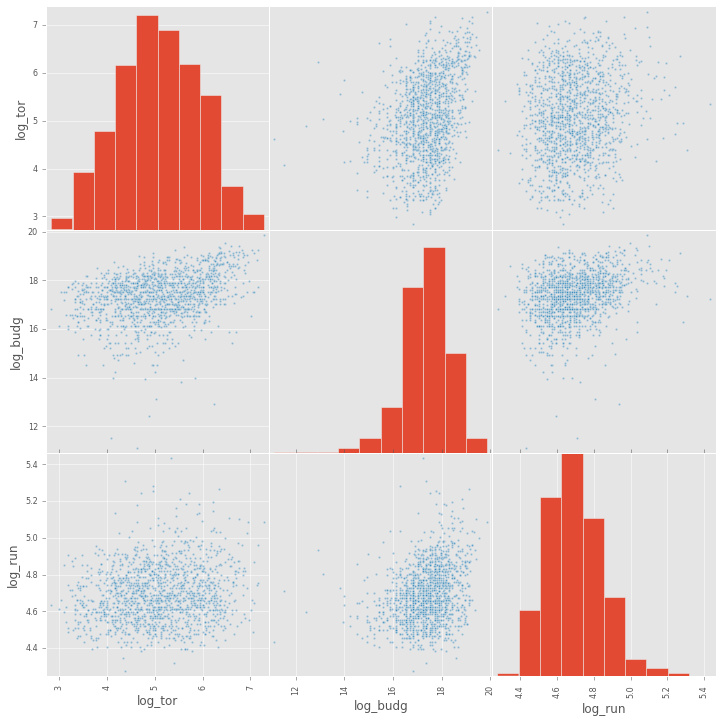

In [22]:
df_sub['log_tor']=np.log(df_sub.Total_Torrents)
df_sub['log_budg']=np.log(df_sub.Prod_Budget)
df_sub['log_run']=np.log(df_sub.Runtime)

trans=df_sub[['log_tor','log_budg', 'log_run']]
pd.tools.plotting.scatter_matrix(trans)

---
# Log Transform

In [23]:
df.head()

,Released,Prod_Budget,Rated,Runtime,Genre,Total_Torrents,Year,Month,Genre_Single
0,2009-12-18,425000000.0,PG-13,162,"Action, Adventure, Fantasy",1450.0,2009,12,Action
1,2015-11-06,300000000.0,PG-13,148,"Action, Adventure, Thriller",647.0,2015,11,Action
2,2012-07-20,275000000.0,PG-13,164,"Action, Adventure, Drama",861.0,2012,7,Drama
3,2012-03-09,275000000.0,PG-13,132,"Action, Adventure, Sci-Fi",723.0,2012,3,Action
4,2010-11-24,260000000.0,PG,100,"Animation, Adventure, Comedy",563.0,2010,11,Comedy


In [24]:
y, x = dmatrices('log_tor ~ log_budg + Genre_Single + log_run', data=df_sub, return_type='dataframe')
x.head()

,Intercept,Genre_Single[T.Adventure],Genre_Single[T.Comedy],Genre_Single[T.Crime],Genre_Single[T.Drama],log_budg,log_run
0,1.0,0.0,0.0,0.0,0.0,19.867600,5.087596
1,1.0,0.0,0.0,0.0,0.0,19.519293,4.997212
2,1.0,0.0,0.0,0.0,1.0,19.432282,5.099866
3,1.0,0.0,0.0,0.0,0.0,19.432282,4.882802
4,1.0,0.0,1.0,0.0,0.0,19.376192,4.605170


In [25]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(x, y)

model.score(x,y)

0.1482271279605667

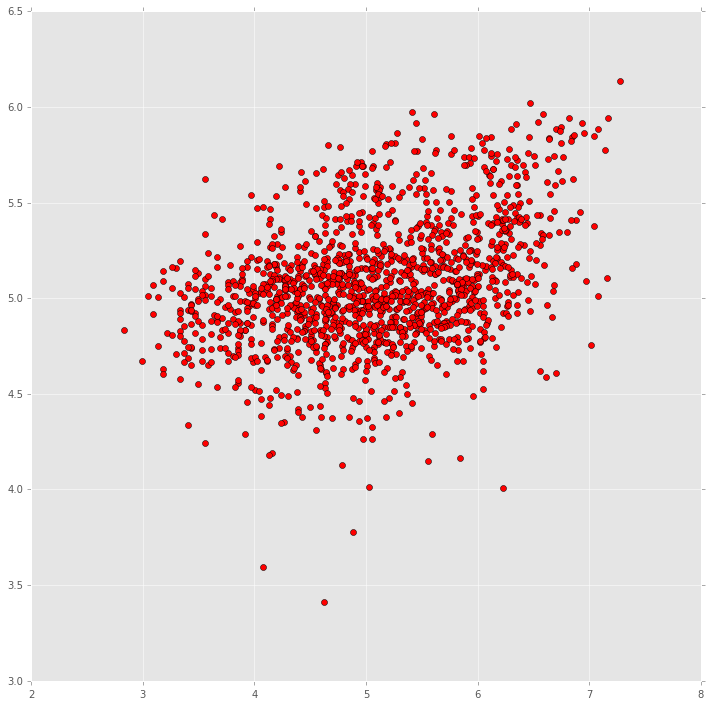

In [26]:
_ = plt.plot(y, model.predict(x), 'ro')

In [27]:
from sklearn import cross_validation as cv
from sklearn import metrics

x_train, x_test, y_train, y_test = cv.train_test_split(x,y,test_size=0.333,random_state=1234)

model = LinearRegression().fit(x_train, y_train)

In [28]:
metrics.mean_squared_error(y_train,model.predict(x_train))

0.63155696142989493

In [29]:
model.score(x_train, y_train)

0.15315955074584919

In [30]:
# reset x, y otherwise errors occur
y, x = dmatrices('log_tor ~ log_budg + Genre_Single + log_run', data=df_sub, return_type='dataframe')

from sklearn.cross_validation import KFold
kf = KFold(len(df_sub), n_folds=10, shuffle=True)

for train_index, test_index in kf:
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    clf2 = LinearRegression().fit(x.iloc[train_index], y.iloc[train_index])

clf2.score(x,y)

0.1477674616311232